# Models (sepsis-pics)


## Common


In [39]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


In [3]:
CV_FOLDS = 3
cv = StratifiedKFold(n_splits=CV_FOLDS)


In [44]:
def plot_roc_file(title, input_path):

    df_roc = pd.read_csv(input_path, sep='\t')
    ax = plt.subplot()

    ax.set_title(title)
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')

    t = [0, 1]
    ax.plot(t, t, '--', c='lightgray')

    x = df_roc['FPR']
    y = df_roc['TPR']
    ax.plot(x, y, 'b-')


In [48]:
def sklearn_cv(model, scoring=None):

    scores = cross_val_score(
        model,
        X,
        y,
        cv=cv,
        scoring=scoring,
    )

    score_name = 'default' if scoring == None else str(scoring)

    print(f'>>> CV Result ({score_name})')
    print(f'Scores: {scores}')
    print(f'  Mean: {scores.mean():.4f}')
    print(f'   Std: {scores.std():.4f}')


## Prepare Data


In [60]:
df_data = pd.read_csv(
    './data_eicu_compact_pics.csv',
    index_col='patientunitstayid',
)

# remove entries with -1
mask_neg1 = (df_data == -1.0).any(axis='columns')
df_data = df_data[~mask_neg1]

df_data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2193 entries, 242505 to 3351713
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          2193 non-null   float64
 1   urine        2193 non-null   float64
 2   wbc          2193 non-null   float64
 3   meanbp       2193 non-null   float64
 4   vasopressor  2193 non-null   int64  
 5   hr           2193 non-null   float64
 6   creatinine   2193 non-null   float64
 7   platelet     2193 non-null   float64
 8   inr          2193 non-null   float64
 9   pt           2193 non-null   float64
 10  ptt          2193 non-null   float64
 11  lactate      2193 non-null   float64
 12  rdw          2193 non-null   float64
 13  bilirubin    2193 non-null   float64
 14  bicarbonate  2193 non-null   float64
 15  pics         2193 non-null   bool   
dtypes: bool(1), float64(14), int64(1)
memory usage: 276.3 KB


In [59]:
X = df_data.drop(columns=['pics'])
y = df_data['pics'] \
    .map(int) \
    .to_numpy() \
    .ravel()


In [56]:
X


,age,urine,wbc,meanbp,vasopressor,hr,creatinine,platelet,inr,pt,ptt,lactate,rdw,bilirubin,bicarbonate
patientunitstayid,,,,,,,,,,,,,,,
242505,90.0,2189.5488,9.6,55.0,0,95.0,1.385714,155.800000,1.000000,13.900000,38.000000,1.200000,17.580000,0.766667,20.857143
243629,87.0,1156.2912,7.1,47.0,1,103.0,1.460000,131.250000,1.500000,17.933333,79.900000,1.950000,15.475000,0.800000,23.200000
244763,47.0,939.6000,2.9,129.0,0,121.0,0.600000,118.666667,1.000000,13.200000,34.000000,1.200000,14.250000,0.500000,27.777778
245906,73.0,5.0976,23.2,171.0,1,114.0,5.590000,154.900000,1.040000,14.000000,30.400000,2.000000,16.310000,0.200000,23.500000
246013,66.0,1055.4624,0.6,61.0,0,84.0,1.070000,40.833333,1.040000,14.100000,25.700000,2.525000,17.916667,0.300000,18.800000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3349260,62.0,2590.4448,12.6,56.0,1,93.0,0.618824,388.142857,1.045000,10.600000,26.000000,1.900000,14.435714,1.850000,29.176471
3350924,53.0,378.8640,4.9,74.0,0,101.0,0.760714,248.142857,1.115000,11.350000,22.000000,1.366667,14.907143,0.300000,36.214286
3351255,75.0,80.4384,23.0,42.0,1,86.0,2.520000,63.000000,1.340000,14.400000,42.666667,4.050000,15.400000,0.633333,18.800000


In [84]:
y


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

## CatBoost


In [21]:
from catboost import CatBoostClassifier, cv as catboost_cv, \
    Pool as CatboostPool
from catboost.utils import get_roc_curve as catboost_roc


In [22]:
catboost_pool = CatboostPool(X, y)


In [23]:
catboost_scores = catboost_cv(
    catboost_pool,
    fold_count=CV_FOLDS,
    logging_level='Silent',
    params={
        'loss_function': 'Logloss',
        'verbose': False,
        'roc_file': 'roc_catboost.tsv',
        'custom_metric': 'AUC',
    },
)


In [34]:
catboost_scores.iloc[-1, -2:]


test-AUC-mean    0.620478
test-AUC-std     0.114691
Name: 999, dtype: float64

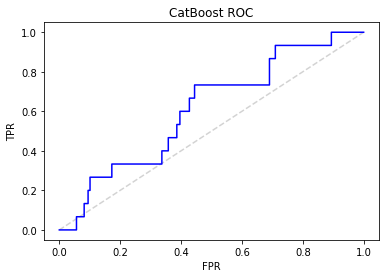

In [37]:
plot_roc_file('CatBoost ROC', './catboost_info/roc_catboost.tsv')


## MLP


In [55]:
from sklearn.neural_network import MLPClassifier

mlp_model = make_pipeline(
    StandardScaler(),
    MLPClassifier(
        hidden_layer_sizes=(100,),
        max_iter=1000,
    ),
)

# sklearn_cv(mlp_model)
sklearn_cv(mlp_model, 'roc_auc')


>>> CV Result (roc_auc)
Scores: [0.45179063 0.46501377 0.42672176]
  Mean: 0.4478
   Std: 0.0159


## Naive Bayes


In [50]:
from sklearn.naive_bayes import ComplementNB

nb_model = ComplementNB()

sklearn_cv(nb_model, 'roc_auc')


>>> CV Result (roc_auc)
Scores: [0.51928375 0.40909091 0.76460055]
  Mean: 0.5643
   Std: 0.1486
